should normalize by the number of publications for each subfield

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, sys

# Get the absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Add src_path to the system path
sys.path.insert(0, src_path)

from utils import mappings

PUBLICATIONS_PATH = "../../data/raw/publication_meta/br_publication_meta.csv"

In [22]:
def plot_subfield_country_heatmap(df, normalize=True):
    # Define the order for subfields (using their full names as in the data)
    subfield_order = [
        "Computer Vision and Pattern Recognition",
        "Information Systems",
        "Computational Theory and Mathematics",
        "Artificial Intelligence",
        "Computer Networks and Communications",
        "Computer Science Applications",
        "Software",
        "Signal Processing",
        "Human-Computer Interaction",
        "Hardware and Architecture",
        "Computer Graphics and Computer-Aided Design",
    ]
    subfield_order = sorted(subfield_order)

    # Define countries and their display order
    country_order = ["US", "PT", "ES", "GB", "FR", "IT", "DE", "CA", "CN", "IN"]

    # Parse JSON columns
    df["subfield"] = df["subfield"].apply(json.loads)
    df["authorships"] = df["authorships"].apply(json.loads)

    # Filter to valid subfields based on display name
    valid_subfields = set(subfield_order)
    df["subfield_name"] = df["subfield"].apply(lambda x: x["display_name"])
    df = df[df["subfield_name"].isin(valid_subfields)]

    # Create a count matrix for international collaborations
    count_matrix = pd.DataFrame(0, index=subfield_order, columns=country_order)

    # Count international collaborations per publication,
    # excluding any author whose country is "BR"
    for _, row in df.iterrows():
        subfield = row["subfield_name"]
        for author in row["authorships"]:
            # Exclude Brazilian authors and keep only valid countries
            countries = [c for c in author.get("countries", []) if c != "BR"]
            valid_countries = [c for c in countries if c in country_order]
            for country in valid_countries:
                count_matrix.loc[subfield, country] += 1

    # Calculate total publications per subfield.
    # Each row/publication in df counts once, regardless of collaboration count.
    publication_counts = df.groupby("subfield_name").size()

    if normalize:
        # Normalize the count by the total number of publications in each subfield.
        # Multiply by 100 to express as a percentage.
        normalized_matrix = count_matrix.div(publication_counts, axis=0).fillna(0) * 100
        data_to_plot = normalized_matrix
        fmt = ".1f"
        cbar_label = "International Collaborations per Publication (%)"
    else:
        data_to_plot = count_matrix
        fmt = "d"
        cbar_label = "Number of International Authors"

    # Rename the subfield names using the provided shortened mapping.
    data_to_plot = data_to_plot.rename(index=mappings.SUBFIELDS_SHORT)

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    fig = sns.heatmap(
        data_to_plot,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        cbar_kws={"label": cbar_label},
        linewidths=0.5,
        vmin=0,
        vmax=30 if normalize else None,
    )

    # Create a descriptive title
    title = "Brazilian Publications: International Collaborations by Subfield"
    if normalize:
        title += "\n(Normalized by Total Publications in Each Subfield)"
    else:
        title += "\n(Absolute Count of Non-Brazilian Authors)"
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Collaborating Country", fontsize=12)
    plt.ylabel("Subfield", fontsize=12)
    plt.xticks(rotation=0, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    plt.savefig("../../results/figures/inter_collabs_heatmap.pdf", format="pdf")

    return fig

In [23]:
publications_df = pd.read_csv(PUBLICATIONS_PATH)

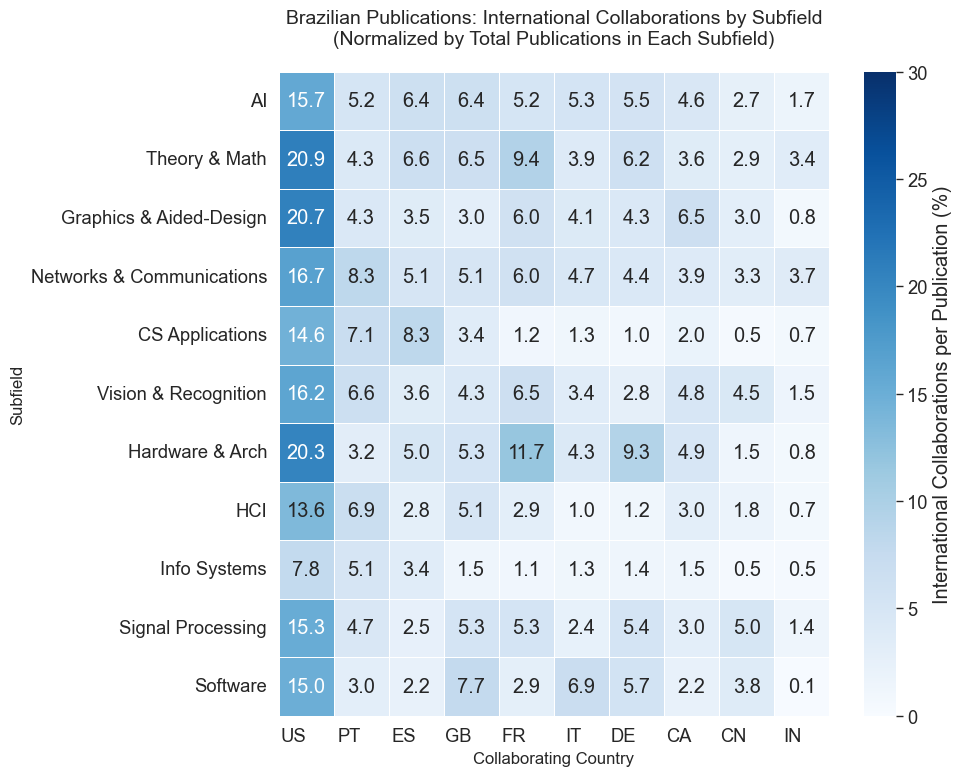

In [24]:
plot_subfield_country_heatmap(publications_df)
plt.show()